In [13]:
import spacy
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
nlp=spacy.load('de_core_news_lg')

In [3]:
HCHS_data=pd.read_excel('/workspaces/de.uke.iam.automapping/experiments/VM_Soarian_HCHS_20210422.xlsx')
print(f"Data length {len(HCHS_data['Langname']) } and length of unique data {len(HCHS_data['Langname'].unique())}")

Data length 1033 and length of unique data 959


In [4]:
HCHS_data['Langname']=HCHS_data['Langname'].replace([' ', ''], np.nan)
HCHS_Langname=HCHS_data['Langname'].str.strip()
HCHS_Langname=HCHS_Langname.dropna(axis=0)

In [5]:
HCHS_Langname=HCHS_Langname.unique()

In [8]:
docs=nlp.pipe(HCHS_Langname)

#### General analysis

In [6]:
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_, i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct, i.has_vector) for i in doc
    ]

In [7]:
def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct", "has_vector"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        #print(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df) 

In [9]:
df=tidy_tokens(docs)

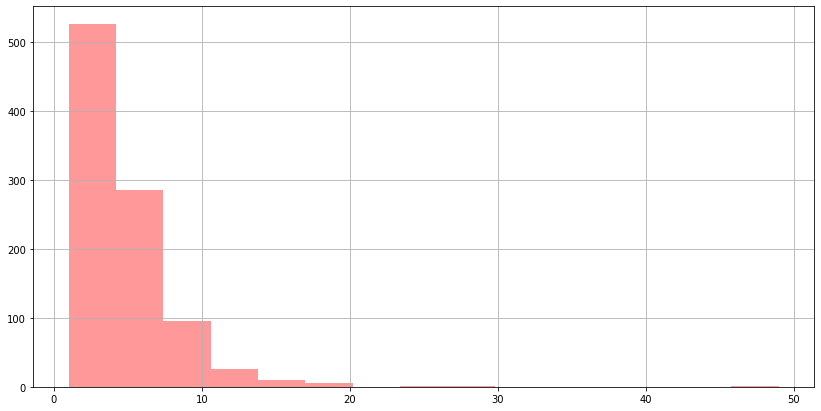

In [10]:
#distibution according number of words per string
df.groupby("doc_id").size().hist(figsize=(14, 7), color="red", alpha=.4, bins=15);

In [15]:
#number of strings which contain verb, or noun, or adjective, or proper noun, or other 
name=['without filter', 'verb', 'noun', 'adjective', 'adverb', ' proper noun', 'other']
result=[df.doc_id.value_counts().size, df.query("pos=='VERB'").doc_id.value_counts().size, df.query("pos=='NOUN'").doc_id.value_counts().size,
    df.query("pos=='ADJ'").doc_id.value_counts().size, df.query("pos=='ADV'").doc_id.value_counts().size,
    df.query("pos=='PROPN'").doc_id.value_counts().size, df.query("pos=='X'").doc_id.value_counts().size]

list_tuples = list(zip(name, result)) 

df_2=pd.DataFrame(list_tuples, columns=['filter', 'count_per_doc'])

<AxesSubplot:xlabel='filter', ylabel='count_per_doc'>

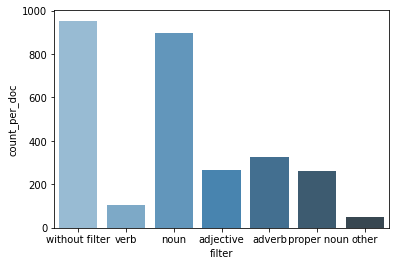

In [16]:
sns.barplot(data=df_2, x='filter', y='count_per_doc', palette="Blues_d")

In [22]:
#examples of each part of speech
name=['noun', 'adverb', 'verb', 'other', 'adjective']
result=[df[df['pos']=='NOUN'].token.unique()[0:3], df[df['pos']=='ADV'].token.unique()[0:3],
    df[df['pos']=='VERB'].token.unique()[0:3], df[df['pos']=='X'].token.unique()[0:3],
    df[df['pos']=='ADJ'].token.unique()[0:3]]

list_tuples = list(zip(name, result)) 
examples=pd.DataFrame(list_tuples, columns=['part of speech', 'example'])

In [23]:
examples

,part of speech,example
0,noun,"[Arzt, Demenz, Diabetes]"
1,adverb,"[Wann, bereits, bekannt]"
2,verb,"[Liegt, diagnostizierte, diagnostiziert]"
3,other,"[a, Monovette, Pulse]"
4,adjective,"[diagnostizierte, diagnostizierter, letzte]"


#### Local analysis

In [24]:
from spacy import displacy#for dependencies

In [25]:
sentence=nlp('Liegt bei ihnen eine vom Arzt diagnostizierte Demenz vor')
displacy.render(sentence, style='dep', jupyter=True, options={'distance':95})

In [26]:
#check examples strings without noun 
docs_with_noun= df[df['pos']=='NOUN']['doc_id'].unique()
list_of_all=df['doc_id'].unique()
docs_without_noun=list(set(list_of_all)-set(docs_with_noun))
docs_without_noun[0:5]

[897, 771, 899, 900, 776]

In [104]:
docs_with_noun

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  90,  92,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 18

In [116]:
p=df[df['doc_id']==1]

In [155]:
for i in docs_with_noun:
    doc=df[df['doc_id']==i]
    a=doc['pos']=='PROPN'
    if a.any():
        print(doc[doc['pos']=='PROPN'])
        

   doc_id token  token_order lemma ent_type tag dep    pos  is_stop  is_alpha  \
7       6   KHK            7   KHK           NE  sb  PROPN    False      True   

   is_digit  is_punct  has_vector  
7     False     False        True  
    doc_id     token  token_order     lemma ent_type   tag  dep    pos  \
8       10  Multiple            8  Multiple           ADJA   nk  PROPN   
11      10        MS           11        MS     MISC    NE  app  PROPN   

    is_stop  is_alpha  is_digit  is_punct  has_vector  
8     False      True     False     False        True  
11    False      True     False     False        True  
   doc_id        token  token_order        lemma ent_type tag dep    pos  \
0      14  Berichtetes            0  Berichtetes      PER  NE  ag  PROPN   

   is_stop  is_alpha  is_digit  is_punct  has_vector  
0    False      True     False     False       False  
   doc_id        token  token_order        lemma ent_type tag  dep    pos  \
2      24       3xCell            

In [160]:
HCHS_Langname[24]

"Biobank: 3xCell Preparation Tube a' 8ml: Abgenommen?"

In [29]:
HCHS_Langname[docs_without_noun[0:5]]

array(['Ferritin', 'Flußsignal der Arteria femoralis communis links',
       'GFR', 'GFR (CKD-EPI)', 'Flußsignal der Arteria poplitea rechts'],
      dtype=object)

In [30]:
#don't know what is it
HCHS_Langname[608]

'Wo sind wir hier?'

In [32]:
for i in HCHS_Langname[docs_without_noun[0:5]]:
    sentence=nlp(i)
    displacy.render(sentence, style='dep', jupyter=True, options={'distance':95})

### Try pattern

In [272]:
from spacy.matcher import Matcher
from spacy.tokens import Span

In [296]:
#examples for manual checking and mapping with SNOMED
test=['Liegt bei Ihnen eine vom Arzt diagnostizierte Demenz vor?',
       'Liegt bei Ihnen ein vom Arzt diagnostizierter Diabetes vor?',
       'Wann war die letzte Injektion?',
       'Hatten Sie bereits einen vom Arzt diagnostizierten Herzinfarkt?',
       'Ist bei Ihnen eine vom Arzt diagnostizierte Herzinsuffizienz bekannt?',
       'Ist bei Ihnen ein vom Arzt diagnostizierter Hypertonus bekannt?',
       'Ist bei Ihnen eine vom Arzt diagnostizierte KHK bekannt?',
       'Rauchen Sie?',
       'Routine Labor: 1xEDTA Monovette 4ml: Abgenommen?']

In [302]:
matcher=Matcher(nlp.vocab)

In [303]:
pattern=[[{'POS':'NUM',"OP": "?"}, {'POS':'ADJ',"OP": "?"}, {'POS':'NOUN', 'LOWER': {'NOT_IN': ['arzt']}}], [{'POS':'PROPN'}]]

In [304]:
matcher.add('Matching', pattern)

In [307]:
export=[]
for i in test:
    matcher=Matcher(nlp.vocab)
    pattern=[[{'POS':'NUM',"OP": "?"}, {'POS':'ADJ',"OP": "?"}, {'POS':'NOUN', 'LOWER': {'NOT_IN': ['arzt']}}], [{'POS':'PROPN'}]]
    matcher.add('FIND', pattern)
    doc=nlp(i)
    print(i)
    matches = matcher(doc)

    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # Get string representation
        span = doc[start:end]  # The matched span
        print(match_id, string_id, start, end, span.text)
        export.append(span.text)

Liegt bei Ihnen eine vom Arzt diagnostizierte Demenz vor?
9304861301553561741 FIND 6 8 diagnostizierte Demenz
9304861301553561741 FIND 7 8 Demenz
Liegt bei Ihnen ein vom Arzt diagnostizierter Diabetes vor?
9304861301553561741 FIND 6 8 diagnostizierter Diabetes
9304861301553561741 FIND 7 8 Diabetes
Wann war die letzte Injektion?
9304861301553561741 FIND 3 5 letzte Injektion
9304861301553561741 FIND 4 5 Injektion
Hatten Sie bereits einen vom Arzt diagnostizierten Herzinfarkt?
9304861301553561741 FIND 6 8 diagnostizierten Herzinfarkt
9304861301553561741 FIND 7 8 Herzinfarkt
Ist bei Ihnen eine vom Arzt diagnostizierte Herzinsuffizienz bekannt?
9304861301553561741 FIND 6 8 diagnostizierte Herzinsuffizienz
9304861301553561741 FIND 7 8 Herzinsuffizienz
Ist bei Ihnen ein vom Arzt diagnostizierter Hypertonus bekannt?
9304861301553561741 FIND 6 8 diagnostizierter Hypertonus
9304861301553561741 FIND 7 8 Hypertonus
Ist bei Ihnen eine vom Arzt diagnostizierte KHK bekannt?
9304861301553561741 FIND 7

In [91]:
list_tuples = list(zip(test, export)) 
df_export=pd.DataFrame(list_tuples, columns=['sentence', 'export'])

In [55]:
translation=['dementia', 'diabetes', 'injection', 'heart attack', 'heart failure', 'hypertonus', 'coronary heart disease', 'smoking']
snomed_match=[4182210, 'several options', 'several options', 'several options', 316139, 'several options', 'several options', 765451]


df_export['translation']=translation
df_export['snomed']=snomed_match

In [56]:
df_export

,sentence,export,translation,snomed
0,Liegt bei Ihnen eine vom Arzt diagnostizierte ...,Demenz,dementia,4182210
1,Liegt bei Ihnen ein vom Arzt diagnostizierter ...,Diabetes,diabetes,several options
2,Wann war die letzte Injektion?,Injektion,injection,several options
3,Hatten Sie bereits einen vom Arzt diagnostizie...,Herzinfarkt,heart attack,several options
4,Ist bei Ihnen eine vom Arzt diagnostizierte He...,Herzinsuffizienz,heart failure,316139
5,Ist bei Ihnen ein vom Arzt diagnostizierter Hy...,Hypertonus,hypertonus,several options
6,Ist bei Ihnen eine vom Arzt diagnostizierte KH...,KHK,coronary heart disease,several options
7,Rauchen Sie?,Rauchen,smoking,765451


#### Try pattern for 100 sentences

In [308]:
export={}
export['sentence']=[]
export['export']=[]
for i in HCHS_Langname[0:100]:
    doc=nlp(i)
    export['sentence'].append(i)
    matches = matcher(doc)
    words=[]

    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # Get string representation
        span = doc[start:end]  # The matched span
        if span.text is not None:
            #print(match_id, string_id, start, end, span.text)
            words.append(span.text)
    export['export'].append(words)
        #else:
        #    export.append('no')

In [309]:
df_export_full=pd.DataFrame(export, columns=['sentence', 'export'])

In [310]:
df_export_full.to_csv('export_full_2.csv', sep=';')

In [311]:
df_export_full

,sentence,export
0,Liegt bei Ihnen eine vom Arzt diagnostizierte ...,"[diagnostizierte Demenz, Demenz]"
1,Liegt bei Ihnen ein vom Arzt diagnostizierter ...,"[diagnostizierter Diabetes, Diabetes]"
2,Wann war die letzte Injektion?,"[letzte Injektion, Injektion]"
3,Hatten Sie bereits einen vom Arzt diagnostizie...,"[diagnostizierten Herzinfarkt, Herzinfarkt]"
4,Ist bei Ihnen eine vom Arzt diagnostizierte He...,"[diagnostizierte Herzinsuffizienz, Herzinsuffi..."
...,...,...
95,Verruca vulgaris/plantaris (Füße/Dornwarzen),"[Verruca, vulgaris, Füße, Dornwarzen]"
96,Andere (z.B. Windpocken | Gürtelrose),"[Windpocken, Gürtelrose]"
97,V.a. Pilzerkrankungen der Haut,"[Pilzerkrankungen, Haut]"
98,Onychomykose (Nagelpilz),"[Onychomykose, Nagelpilz]"


In [295]:
sentence=nlp('Parenterale Ernährung?')
displacy.render(sentence, style='dep', jupyter=True, options={'distance':95})